In [2]:
# Carga de contexto y librerias para el notebook :D
%load_ext kedro.ipython
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

The kedro.ipython extension is already loaded. To reload it, use:
  %reload_ext kedro.ipython


In [3]:
df = catalog.load("Features_training_v2")   # lee el dataset del catálogo
list(df.columns)  

[10/25/25 03:08:49] INFO     Loading data from Features_training_v2 (ParquetDataset)...        ]8;id=351232;file://C:\Users\AlexandreKz\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=273816;file://C:\Users\AlexandreKz\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

['Monetary', 'TimeSinceLastTxn', 'IsLateNight', 'AmountZScoreByLocation', 'IsWeekend']

In [4]:
# =========================================================
# ⚙️ RIDGE REGRESSION – PREDICCIÓN DE MONETARY
# =========================================================
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# =========================================================
# 1️⃣ Variables dependiente e independientes
# =========================================================
X = df[["AmountZScoreByLocation", "TimeSinceLastTxn", "IsLateNight", "IsWeekend"]]
y = df["Monetary"]

# =========================================================
# 2️⃣ División Train/Test
# =========================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# =========================================================
# 3️⃣ Escalamiento de variables
# =========================================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# =========================================================
# 4️⃣ Modelo Ridge + Cross Validation
# =========================================================
ridge = Ridge(alpha=1.0, random_state=42)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

cv_r2 = cross_val_score(ridge, X_train_scaled, y_train, cv=cv, scoring="r2")
cv_rmse = np.sqrt(-cross_val_score(ridge, X_train_scaled, y_train, cv=cv, scoring="neg_mean_squared_error"))

print("=== Cross Validation Results (5-Fold) ===")
print("R² promedio:", round(cv_r2.mean(), 4))
print("R² desviación:", round(cv_r2.std(), 4))
print("RMSE promedio:", round(cv_rmse.mean(), 2))

# =========================================================
# 5️⃣ Entrenamiento final y evaluación en test
# =========================================================
ridge.fit(X_train_scaled, y_train)
y_pred = ridge.predict(X_test_scaled)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

results_ridge = {
    "model_name": "RidgeRegression",
    "r2_mean_cv": round(cv_r2.mean(), 4),
    "r2_std_cv": round(cv_r2.std(), 4),
    "r2_test": round(r2, 4),
    "rmse": round(rmse, 2),
    "mae": round(mae, 2)
}

print("\n=== Resultados en Test ===")
print(results_ridge)

# =========================================================
# 6️⃣ Coeficientes del modelo
# =========================================================
coef_df_ridge = pd.DataFrame({
    "Variable": X.columns,
    "Coeficiente": ridge.coef_.round(4)
})
print("\n=== Coeficientes del modelo Ridge ===")
display(coef_df_ridge)

=== Cross Validation Results (5-Fold) ===
R² promedio: 0.7007
R² desviación: 0.0019
RMSE promedio: 503.24

=== Resultados en Test ===
{'model_name': 'RidgeRegression', 'r2_mean_cv': np.float64(0.7007), 'r2_std_cv': np.float64(0.0019), 'r2_test': 0.704, 'rmse': np.float64(500.32), 'mae': 304.02}

=== Coeficientes del modelo Ridge ===


,Variable,Coeficiente
0,AmountZScoreByLocation,752.0950
1,TimeSinceLastTxn,166.9971
2,IsLateNight,1.0308
3,IsWeekend,2.2692


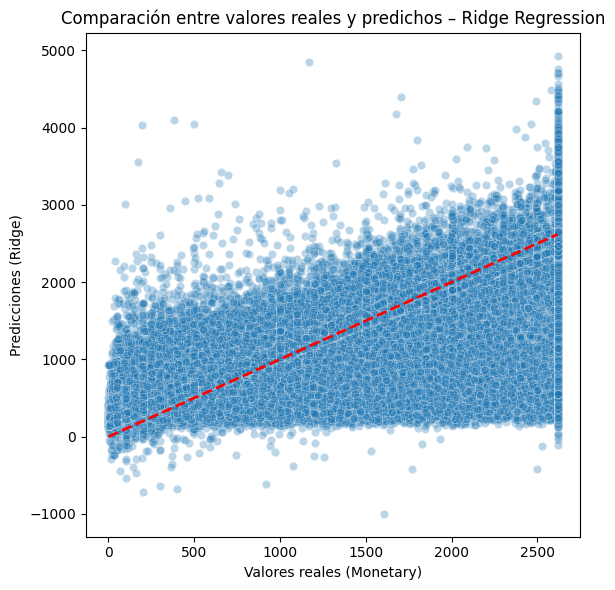

In [5]:
# =========================================================
# 🎯 Scatter Plot – Ridge Regression
# =========================================================
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Valores reales (Monetary)")
plt.ylabel("Predicciones (Ridge)")
plt.title("Comparación entre valores reales y predichos – Ridge Regression")
plt.tight_layout()
plt.show()

# el siguiente grafico de residuos debe verse centrado y simetrico para confirmar que no hay sesgo 

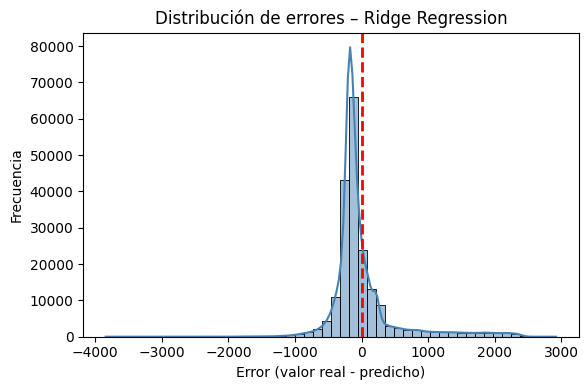

In [6]:
# =========================================================
# 📊 Distribución de errores – Ridge Regression
# =========================================================
residuals = y_test - y_pred

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.histplot(residuals, bins=50, kde=True, color="steelblue")
plt.axvline(0, color="red", linestyle="--", lw=2)
plt.title("Distribución de errores – Ridge Regression")
plt.xlabel("Error (valor real - predicho)")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

# 📊 Interpretación del gráfico de errores

# ✅ Centrado en 0:
# La línea roja marca el “error medio”, y como ves, el grueso de la distribución está justo alrededor de 0 →
# ➡️ El modelo no tiene sesgo sistemático, es decir, no tiende a sobrestimar ni subestimar el gasto total.

# ✅ Forma de campana (ligeramente asimétrica):

# La mayoría de los errores están en ±500 unidades, que coincide con tu RMSE ≈ 500.

# Los extremos (colas) son pocos, lo que indica que solo unos pocos clientes tienen gastos fuera del rango esperado.

# Es normal en datasets financieros con outliers (clientes “premium” o muy inactivos).

# ✅ Curtosis leve (pico afilado):
# → La mayor parte de las predicciones son muy cercanas al valor real, lo que es una excelente señal de estabilidad.

# Predicciones balanceadas y alta precision